# Forecasting Product Sales Using Time Series Analysis Methods


We have data on product sales in stores for 5 years (50 items, 10 stores). We will experiment with different models to find the best one for forecasting daily sales for one of the products in one of the stores for the next month.

**Objectives**

During the project, we'll accomplish the following:

1. **Data Preparation**: Prepare the data for analysis, ensuring it was suitable for modeling.
1. **Time Series Decomposition**: Decompose the time series into its components, assess seasonality, identify significant lags relevant for forecasting.
1. **Feature Engineering**: Enrich the dataset with date-based features to enhance its predictive power.
1. **Model Experimentation**: Conduct experiments with various forecasting models and identify the best model for our specific case.
1. **Backtesting**: Perform backtesting on the best-performing model to evaluate its predictive accuracy on historical data.

**Dataset**

Dataset:

Data from Kaggle competition: https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview

Download dataset from Google Drive: https://drive.google.com/file/d/1F_fr2hseqyz5Xw9B6DF-8HorMqwqkn2N/view?usp=sharing



In [1]:
# Install darts library for working with TimeSeries data

!pip install darts --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.2/934.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.7/314.7 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.5/273.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.0 MB/s eta 0:00:00

In [2]:
# Import libraries

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import numpy as np
import holidays
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
from darts.utils.statistics import plot_acf, check_seasonality
from darts import TimeSeries
from darts.models import NaiveSeasonal, NaiveDrift, ExponentialSmoothing, ARIMA, AutoARIMA, Prophet, RNNModel
from statsmodels.tsa.statespace.sarimax import SARIMAX
from darts.metrics import mape
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler
from statsmodels.graphics.gofplots import qqplot
from darts.utils.statistics import plot_residuals_analysis
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts import concatenate

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## 1. Data Loading

First, we will load data from the train.csv.zip file using the Pandas library. Following steps:

  1. Convert the date column to datetime format.
  1. Set the date column as the index for the DataFrame.
  1. Display the first 10 rows of the resulting DataFrame along with the DataFrame’s summary information.

In [3]:
# Download dataset from the shared link to Google Drive

train_file_id = '1F_fr2hseqyz5Xw9B6DF-8HorMqwqkn2N'
train_file_name = 'train.csv'
!gdown {train_file_id} -O {train_file_name}

# Read dataset

raw_df = pd.read_csv(train_file_name)
print('Original dataset:')
display(raw_df.head(10))

# Convert date to datetime format

raw_df['date']=pd.to_datetime(raw_df['date'])
raw_df.set_index('date', inplace = True)

Downloading...
From: https://drive.google.com/uc?id=1F_fr2hseqyz5Xw9B6DF-8HorMqwqkn2N
To: /content/train.csv
100% 17.3M/17.3M [00:00<00:00, 64.7MB/s]
Original dataset:


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


In [4]:
raw_df.tail()

,store,item,sales
date,,,
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74
2017-12-30,10,50,62
2017-12-31,10,50,82


In [5]:
raw_df[(raw_df['item']==2)&(raw_df['store']==1)].head(30)

,store,item,sales
date,,,
2013-01-01,1,2,33
2013-01-02,1,2,43
2013-01-03,1,2,23
2013-01-04,1,2,18
2013-01-05,1,2,34
2013-01-06,1,2,38
2013-01-07,1,2,27
2013-01-08,1,2,28
2013-01-09,1,2,34


The indices are now represented as dates in datetime format.

The dataset includes data from January 1, 2013, to December 31, 2017.

## 2. Data Analysis

Let’s start by exploring the data to gain some insights. We have information on 10 stores, each carrying 50 items. Our goal is to examine the trends for each item across different stores.

In [6]:
colors = plt.cm.tab10(np.arange(10))

### 2.1. General Overview

Let's see mean sales per product and store.

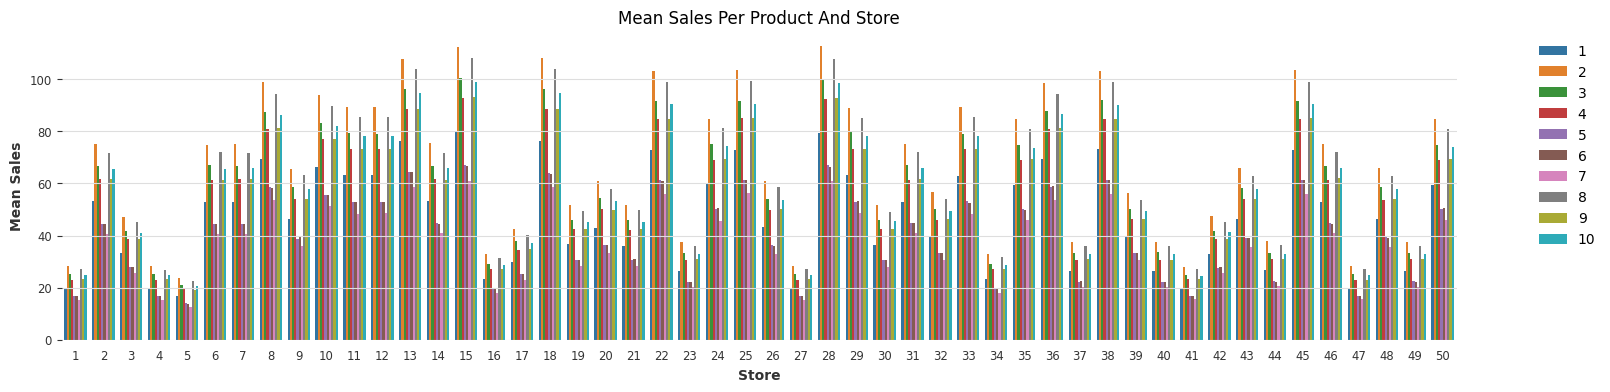

In [7]:
grouped_df1 = raw_df.groupby(["store", "item"]).agg({'sales':'mean'}).reset_index()
plt.figure(figsize=(18, 4))
sns.barplot(x="item", y="sales", hue="store", data=grouped_df1, palette="tab10")
plt.title('Mean Sales Per Product And Store')
plt.xlabel('Store')
plt.ylabel('Mean Sales')
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


**Conclusions**

1. There is a significant variation in sales volumes of products across different stores.
1. The percentage distribution of product sales volumes looks similar across different stores.

### 2.2. Cumulative Percentage of Product Sales by Store

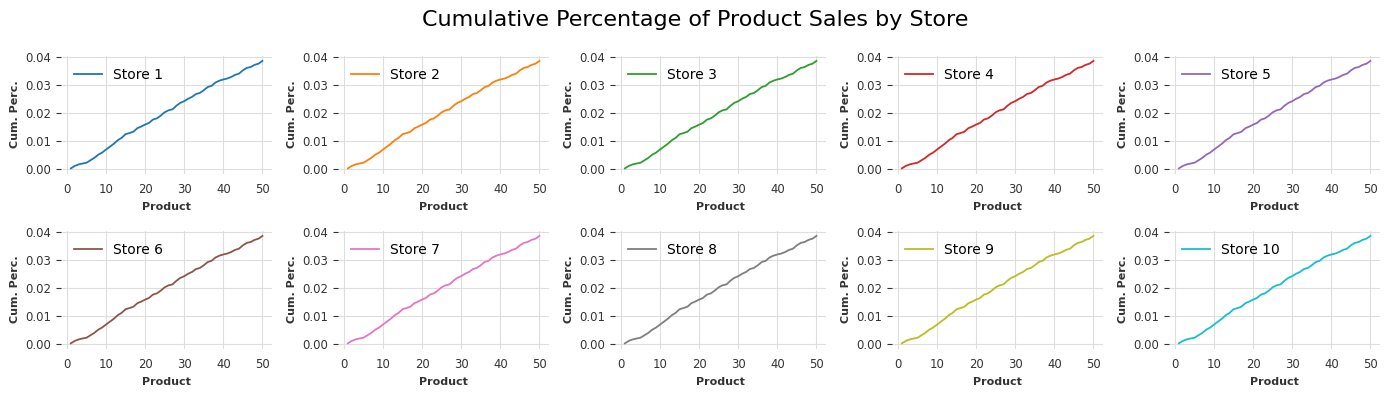

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(14,4))
fig.suptitle('Cumulative Percentage of Product Sales by Store', fontsize=16)
for i, ax in enumerate(axes.flatten()):
  data = grouped_df1[grouped_df1['store']==i+1]
  data = data.copy()
  data['cum_sum'] = data['sales'].cumsum()
  data['cum_percentage'] = data['cum_sum']/data['cum_sum'].sum()
  ax.plot(data['item'], data['cum_percentage'], color=colors[i], label=f'Store {i+1}')
  ax.legend(loc='upper left')
  ax.set_xlabel('Product', fontsize=8)
  ax.set_ylabel('Cum. Perc.', fontsize=8)
plt.tight_layout()
plt.show()

**Conclusions**

Now we see that the percentage distribution of product sales across various stores is really consistent.

### 2.3 Average Daily Sales

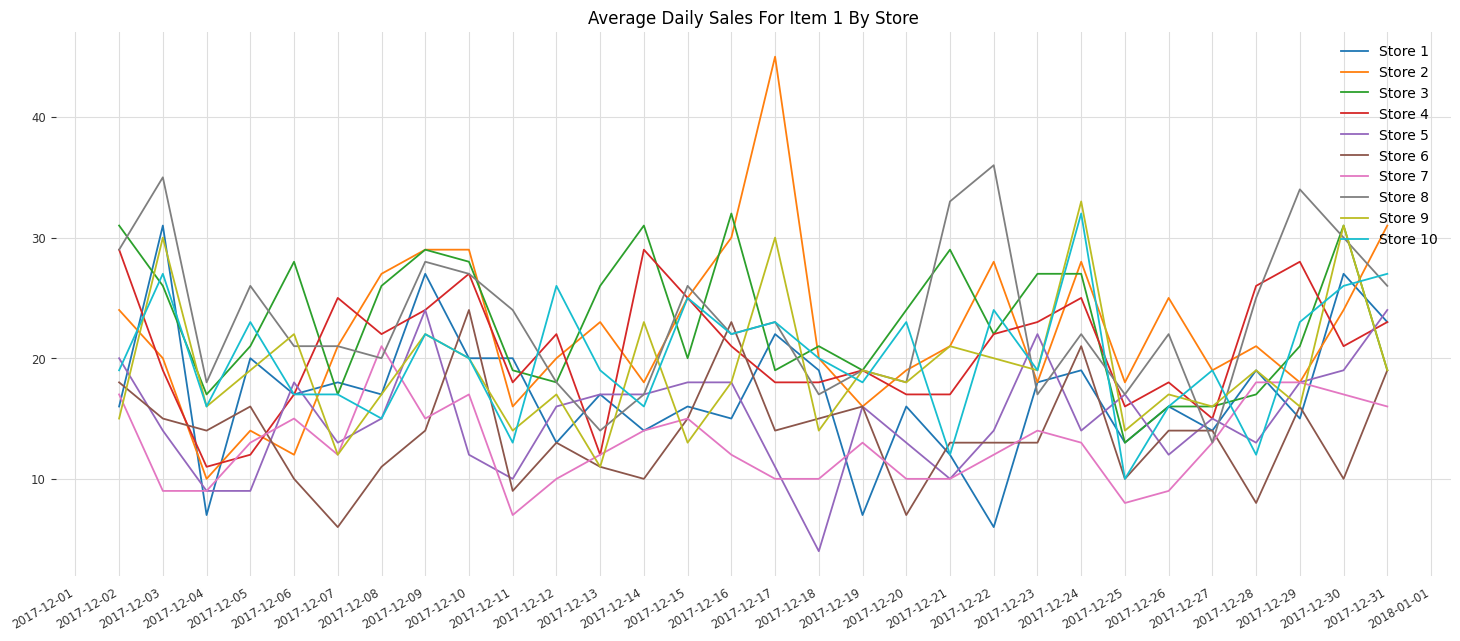

In [18]:
grouped_df2=raw_df.groupby(['date','store','item']).agg({'sales':'sum'}).reset_index()

plt.figure(figsize=(18,8))
for i in np.arange(1,11,1):
  data = grouped_df2[(grouped_df2['item']==1)&(grouped_df2['store']==i)&(grouped_df2['date']>'2017-12-01')]
  plt.plot(data['date'],data['sales'], label=f'Store {i}', color=colors[i-1])
plt.title('Average Daily Sales For Item 1 By Store')
plt.legend(loc='upper right')

# Formatting X axis in date format
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=1))
plt.gcf().autofmt_xdate()

plt.show()


## 3. Time series Decomposition

Let's analyze product number 1 from store number 1. We will decompose the time series data for this item using the additive model to separate it into trend, seasonality, and residuals using the statsmodels library.



In [ ]:
# Extract data for product 1 from store 1

mask = (raw_df['item']==1)&(raw_df['store'] == 1)
raw_df_item1_store1 = raw_df[mask]
raw_df_item1_store1

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
...,...,...,...
2017-12-27,1,1,14
2017-12-28,1,1,19
2017-12-29,1,1,15


In [ ]:
# Define decomposition function

def decompose_plot(df, period):
  # decompose data
  decomposed=seasonal_decompose(df, model='additive', period=period)

  # plot decomposed data
  fig = decomposed.plot()
  fig.set_size_inches((14, 6))
  plt.suptitle(f'Decomposition of Time Series with period={period}', fontsize=16)
  fig.tight_layout()
  plt.show()
  qqplot(decomposed.resid.dropna())
  plt.title('Q-Q Plot of Residuals')
  plt.show()
  return decomposed

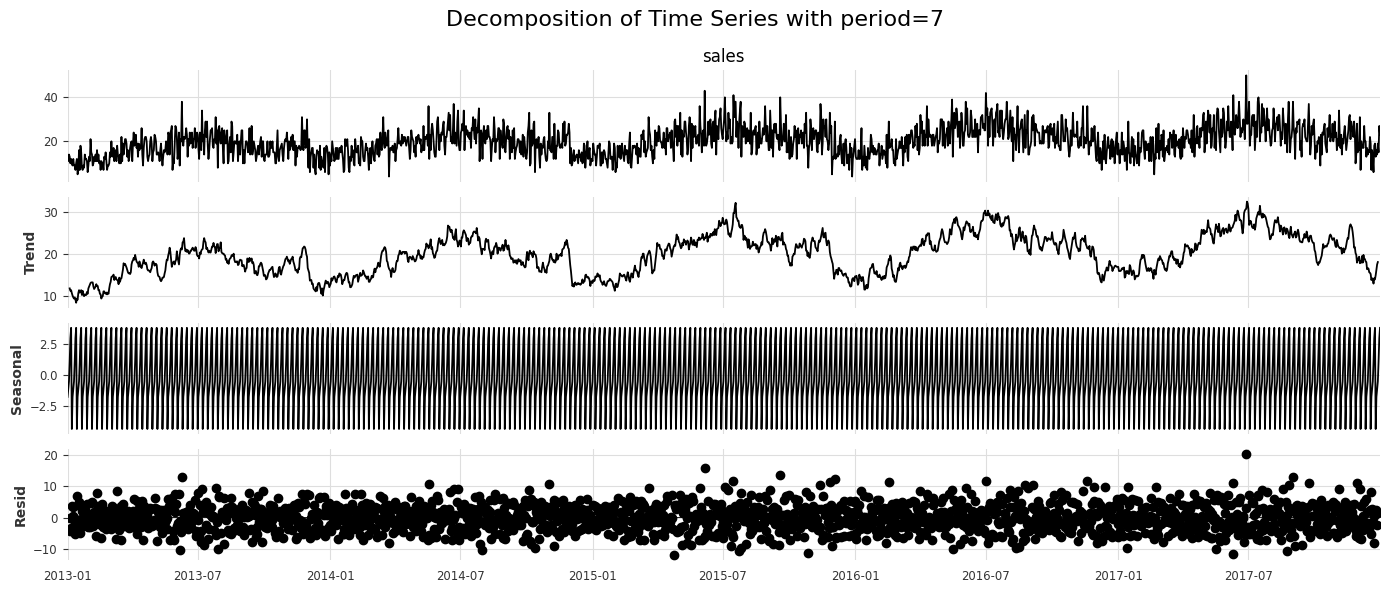

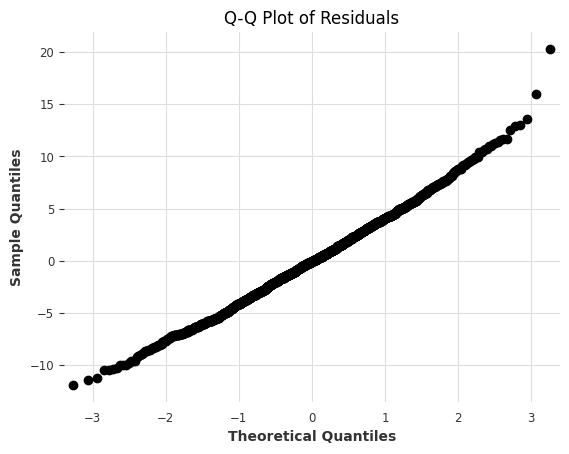

In [ ]:
# Decompose data with seasonal period=7

decompose_7=decompose_plot(raw_df_item1_store1['sales'],7)

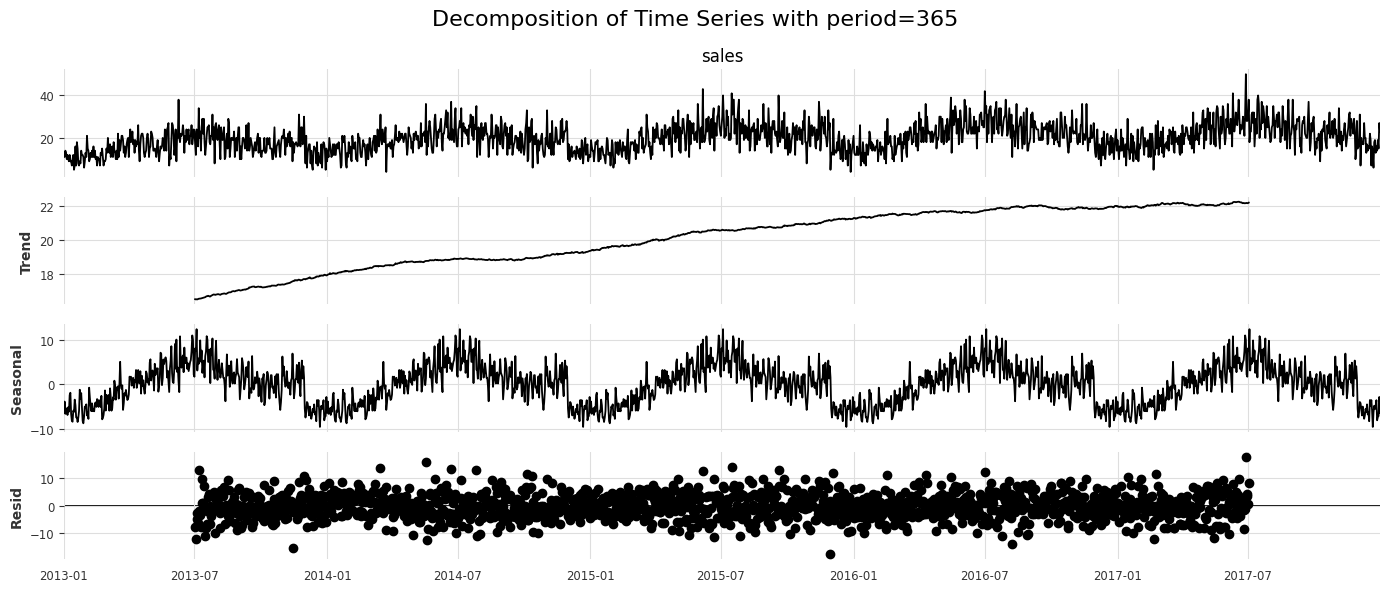

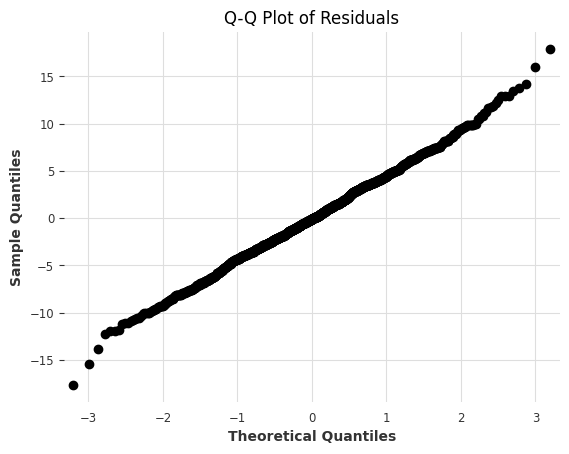

In [ ]:
# decompose data with seasonal period=1 year
decompose_365=decompose_plot(raw_df_item1_store1['sales'],365)

**Conclusions**

1. We performed data decomposition and found a general upward trend, as well as two seasonal components: weekly and yearly.
1. The residuals are approximately normal and don`t have any pattern.

In [ ]:
raw_df_item1_store1

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
...,...,...,...
2017-12-27,1,1,14
2017-12-28,1,1,19
2017-12-29,1,1,15


## 4. Creating TimeSeries type object

In [ ]:
# Create TimeSeries object

series = TimeSeries.from_dataframe(raw_df_item1_store1, value_cols = 'sales')
series

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

## 5. Splitting Data into Train and Validation sets

Let's split the data into training and validation sets, ensuring that the validation set contains data from the last 3 months.

First element of validation set has index: 2017-10-01 00:00:00


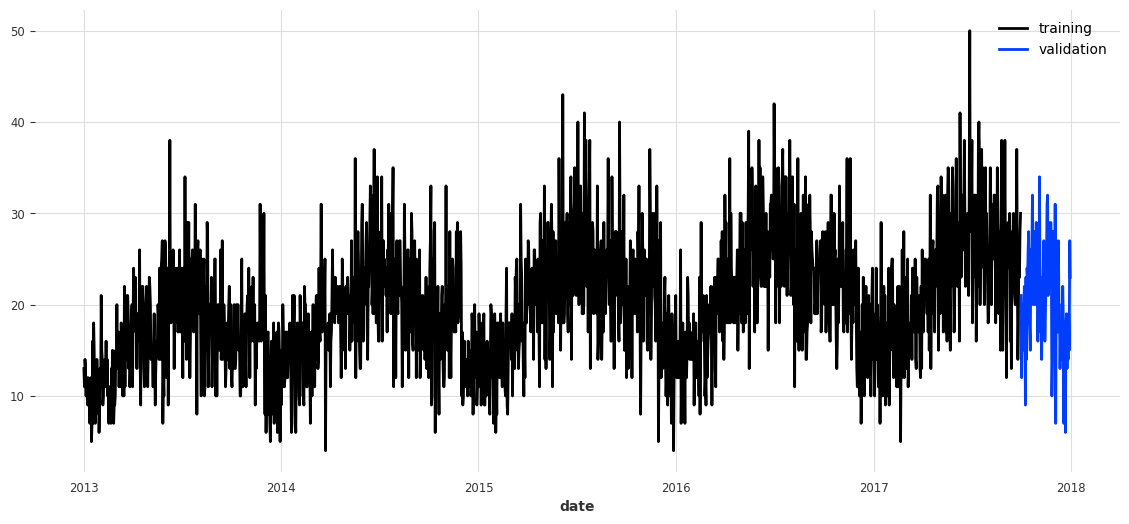

In [ ]:
# Split series

series_train, series_val = series.split_before(pd.Timestamp('2017-10-01'))
print(f'First element of validation set has index: {series_val.time_index[0]}')

# Visualize train and validation series

plt.figure(figsize=(14,6))
series_train.plot(label="training")
series_val.plot(label="validation")
plt.show()

## 6. Partial ACF

<Figure size 3000x600 with 0 Axes>

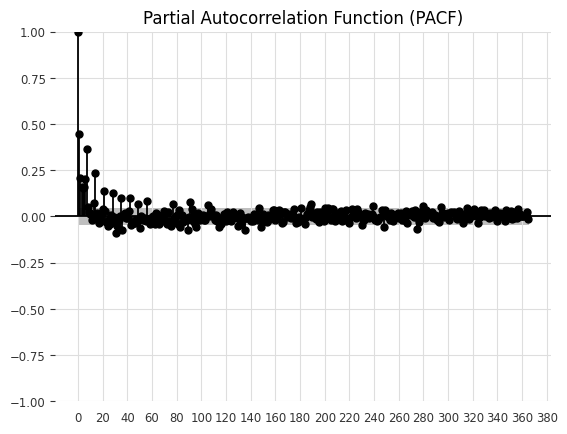

In [ ]:
# Build partial ACF

plt.figure(figsize=(30, 6))
plot_pacf(series.values(), lags=365, method='ywm')
plt.xticks(ticks=np.arange(0,400,20))
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [ ]:
# Calculate the PACF and confidence intervals for evaluating lag significance.

pacf_series = pd.Series(pacf(raw_df_item1_store1['sales'], nlags=60))
conf_int = 1.96/(raw_df_item1_store1.shape[0])**0.5
significant_lags = pacf_series[(pacf_series>conf_int)|(pacf_series<-conf_int)].index
print(f'Statistically significant lags \n: {significant_lags}')

Statistically significant lags 
: Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 21, 24, 28, 31, 32, 35, 36, 42, 49,
       50, 56],
      dtype='int64')


The statistically significant lags are 1-8, 13, 14, 21, 24, 28,31, 32, 35, 36, 42 and so on.

It can be assumed that there is a seasonality with a period of 7.

The important lags for forecasting are 1-8 and those that are multiples of 7.

## 7. Seasonality

Now we`ll identify the seasonality of the training series.

In [ ]:
for m in range (2,25):
  is_seasonal, period = check_seasonality(series_train, m=m, alpha=0.05)
  if is_seasonal:
    print(f'Identified seasonality at period={period}')

Identified seasonality at period=7
Identified seasonality at period=14
Identified seasonality at period=21


Seasonality of the training series has been confirmed with a period of 7.

## Forecasting - Naive Seasonal + Naive Drift

Next, we will experiment with different models for time series forecasting. We will start by attempting to forecast the time series using a naive model Naive Seasonal and Naive Drift.

In [ ]:
# Define fit and forecast function

def fit_(model,train,val):
  model.fit(train)
  forecast = model.predict(len(val))
  return forecast

In [ ]:
# Define calculating mape function

def eval_model(val, forecast, model_name):
  mape_ = mape(val, forecast)
  print(f"Model {model_name} obtains MAPE: {mape_:.2f}%")
  return mape_

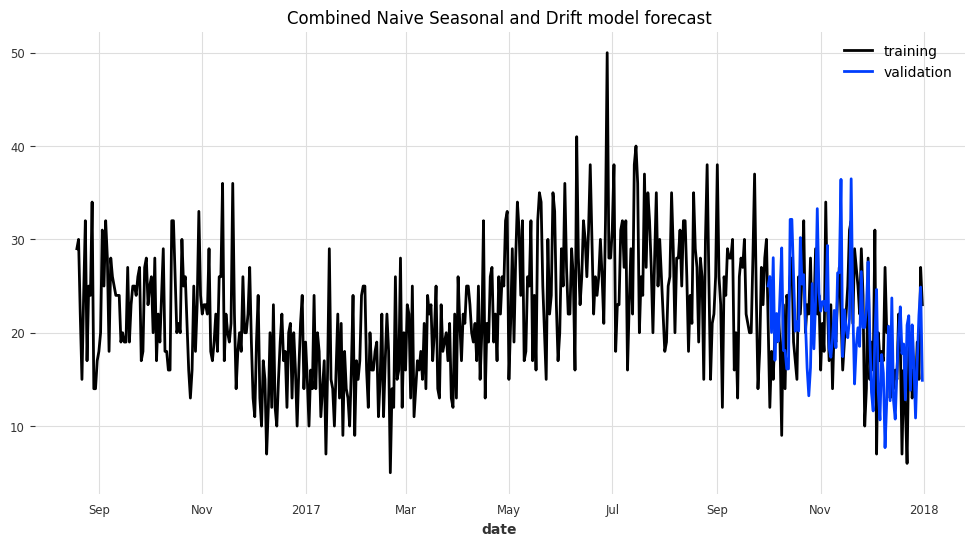

In [ ]:
# Implement Naive model

seasonal = NaiveSeasonal(K=365)
drift = NaiveDrift()
seasonal_forecast = fit_(seasonal, series_train, series_val)
drift_forecast = fit_(drift, series_train, series_val)
combined_forecast = seasonal_forecast+drift_forecast-series_train.last_value()

# Plot naive model

plt.figure(figsize=(12,6))
series[-500:].plot(label="training")
combined_forecast.plot(label="validation")
plt.title('Combined Naive Seasonal and Drift model forecast')
plt.show()

In [ ]:
eval_model(series_val, combined_forecast, 'Combined Naive Seasonal and Drift model');

Model Combined Naive Seasonal and Drift model obtains MAPE: 34.26%


The model captured the general pattern of the data but failed to capture significant fluctuations. The model's MAPE is 34.26%, indicating that the model's quality is still suboptimal.

## XGBoost Model

Model XGBModel obtains MAPE: 24.53%


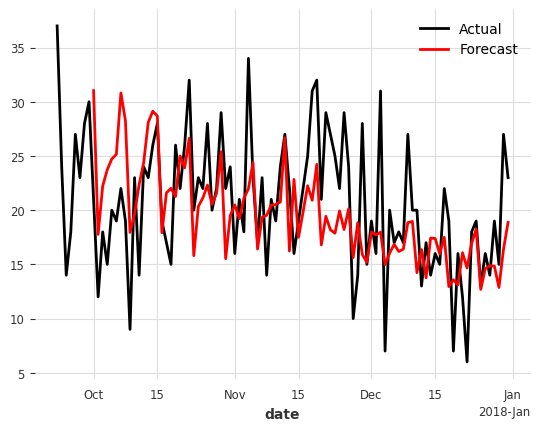

''

In [ ]:
# Define dataset enrichment function

def enrich_with_date_features(series):
   series=series.add_datetime_attribute('year')
   series=series.add_datetime_attribute('quarter')
   series=series.add_datetime_attribute('month')
   series=series.add_datetime_attribute('week')
   series=series.add_datetime_attribute('dayofyear')
   series=series.add_datetime_attribute('dayofweek')
   series=series.add_holidays('US')
   series = series.stack(TimeSeries.from_times_and_values(series.time_index, np.sin(series.time_index.dayofyear)+1, columns='sin_dayofyear'))
   series = series.stack(TimeSeries.from_times_and_values(series.time_index, np.cos(series.time_index.dayofyear)+1, columns='cos_dayofyear'))
   return series

# Enrich train and validation datasets with additional data

train_transformed = enrich_with_date_features(series_train)
val_transformed = enrich_with_date_features(series_val)

# Scale data

scaler = Scaler()
train_transformed = scaler.fit_transform(train_transformed)
val_transformed = scaler.transform(val_transformed)

# Create list of lags used for forecasting

lags = np.arange(-1, -15, -1).tolist()
lags.append(-365)

# XGBoost model

model_xgb = XGBModel(
    lags=lags,
    output_chunk_length=1,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)

# Train model

model_xgb.fit(train_transformed)
xgb_forecast = scaler.inverse_transform(model_xgb.predict(len(series_val)))
eval_model(series_val, xgb_forecast['sales'],type(model_xgb).__name__)
series[-100:]['sales'].plot(label='Actual')
xgb_forecast['sales'].plot(label='Forecast', color='red')
plt.legend()
plt.show()
;



**Conclusions**

1. The model has a better MAPE than the naive model: 24.53% compared to 34.26%, but this value is still not very high.
1.The model captures the overall trend but fails to replicate significant fluctuations in the time series data. Over time, the model "smooths" the data fluctuations, leading to even greater error.
1. To improve the model, we can experiment with covariates and tune the optimal hyperparameters.

## 10. Exponential Smoothing Model.

In [ ]:
# Define vizualize function

def plot_results(series, forecast):
  plt.figure(figsize=(12,6))
  series.plot(label='Actual')
  forecast.plot(label='Forecast', color='red')
  plt.legend()
  plt.show()

# Define fit model and plot function

def fit_and_plot(model, series, train, val):
  model.fit(train)
  forecast=model.predict(len(val))
  plot_results(series, forecast)
  eval_model(val, forecast, type(model).__name__)

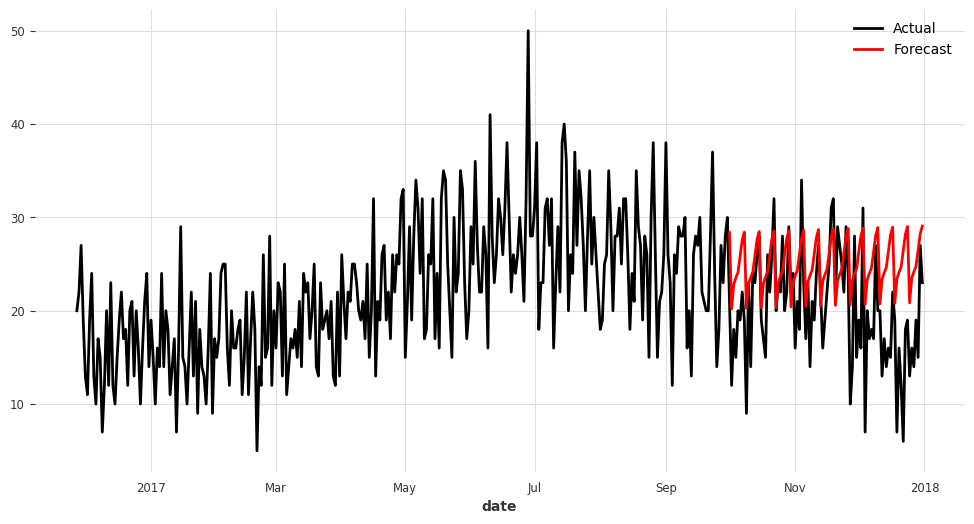

Model ExponentialSmoothing obtains MAPE: 39.01%


In [ ]:
# Implement Exponential Smoothing model

model = ExponentialSmoothing()
fit_and_plot(model, series[-400:], series_train, series_val)

**Conclusions**

The model has a relatively high level of MAPE, indicating its low accuracy.

## 11. ARIMA Model

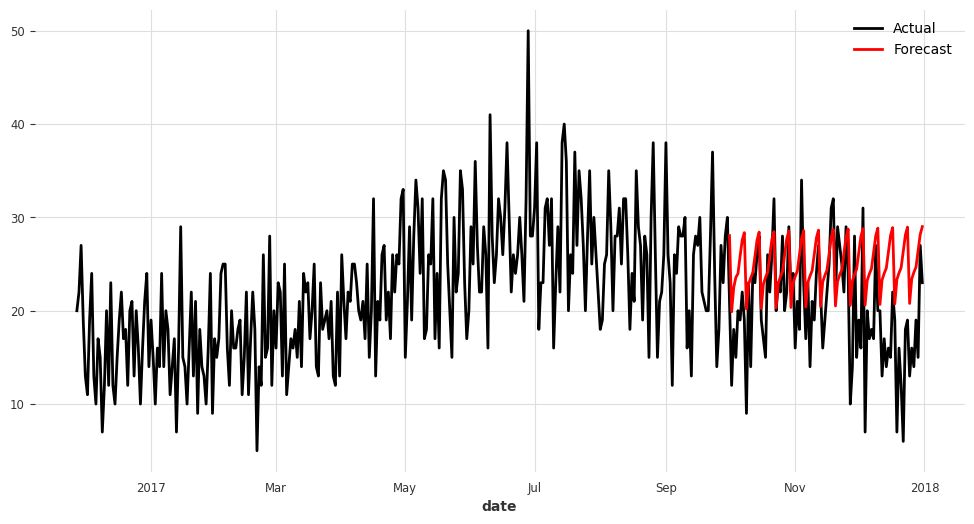

Model ARIMA obtains MAPE: 38.74%


In [ ]:
# Implement ARIMA Model

model = ARIMA(1,1,5, seasonal_order=(1,1,1,7))
fit_and_plot(model, series[-400:], series_train, series_val)

**Conclusions**

The model also has a relatively high level of MAPE, indicating its low accuracy.

## 12. AutoARIMA

Let's try to find the optimal model parameters using the AutoARIMA model.

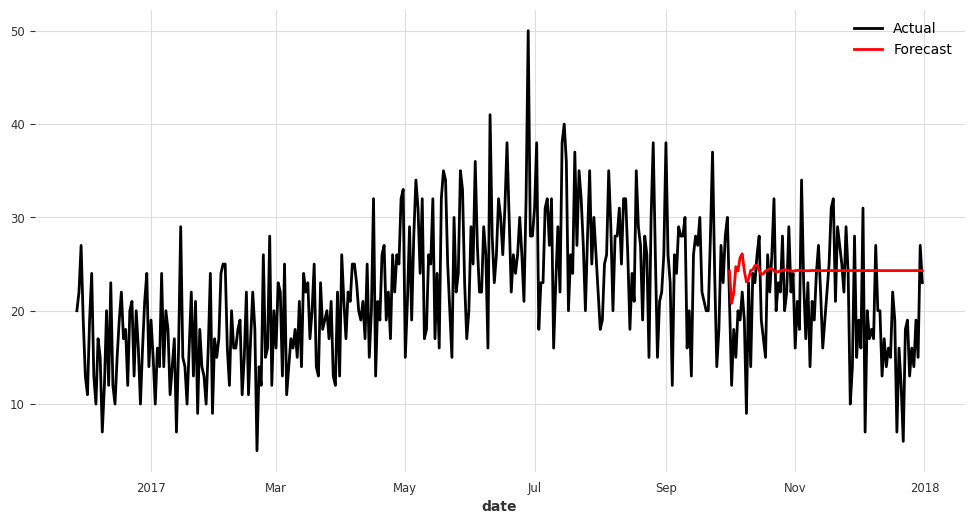

Model AutoARIMA obtains MAPE: 39.53%


In [ ]:
# Implement AutoArima model

model = AutoARIMA(start_p=1, max_p=12, start_q=1)
fit_and_plot(model, series[-400:], series_train, series_val)

Using the AutoARIMA model did not improve the previous result. The MAPE level slightly increased to 39.53%.

## 13. Prophet Model

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpla3j5ss0/_cbq9m6v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpla3j5ss0/jn8vavz9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77718', 'data', 'file=/tmp/tmpla3j5ss0/_cbq9m6v.json', 'init=/tmp/tmpla3j5ss0/jn8vavz9.json', 'output', 'file=/tmp/tmpla3j5ss0/prophet_model_5bktwpk/prophet_model-20241030015229.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:52:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


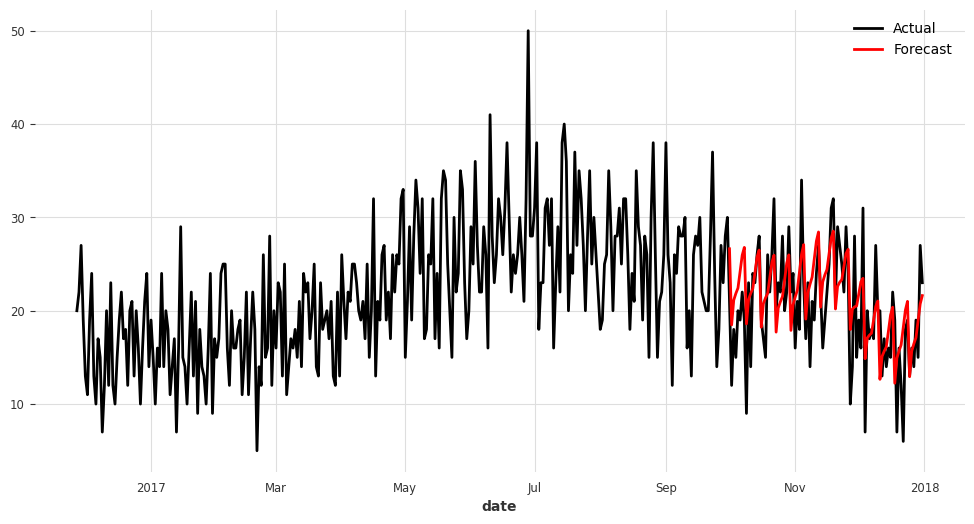

Model Prophet obtains MAPE: 23.80%


In [ ]:
# Implement Prophet model

model = Prophet()
fit_and_plot(model, series[-400:], series_train, series_val)

**Conclusions**

This model has the best MAPE level (23.8%) among all the models considered.

## 14. RNN Model

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
7         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

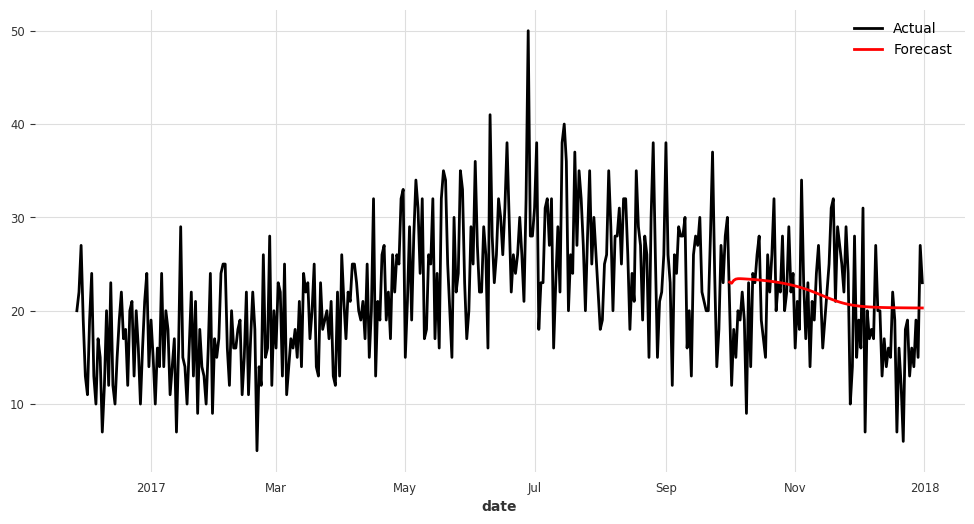

Model RNNModel obtains MAPE: 30.26%


In [ ]:
# Implement RNN model

model = RNNModel(model='LSTM', input_chunk_length=12, n_epochs=100)
fit_and_plot(model, series[-400:], series_train, series_val)

**Conclusions**

1. With the current settings, the model forecasted the overall trend but failed to capture seasonal fluctuations, indicating a need for further tuning.
1. The MAPE level is low (30.26%).

## 15. Backtesting

We will perform a backtest of the model that showed the best results (Prophet) over a period of 1 year with a 1-month forecast.

DEBUG:cmdstanpy:input tempfile: /tmp/tmpla3j5ss0/9t706xbh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpla3j5ss0/224cs88i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98699', 'data', 'file=/tmp/tmpla3j5ss0/9t706xbh.json', 'init=/tmp/tmpla3j5ss0/224cs88i.json', 'output', 'file=/tmp/tmpla3j5ss0/prophet_modelc1k9nryh/prophet_model-20241030020325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:03:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:03:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  0%|          | 0/12 [00:00<?, ?it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpla3j5ss0/9rqxkesd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpla3j5ss0/fenfykhn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG

MAPE = 24.45%


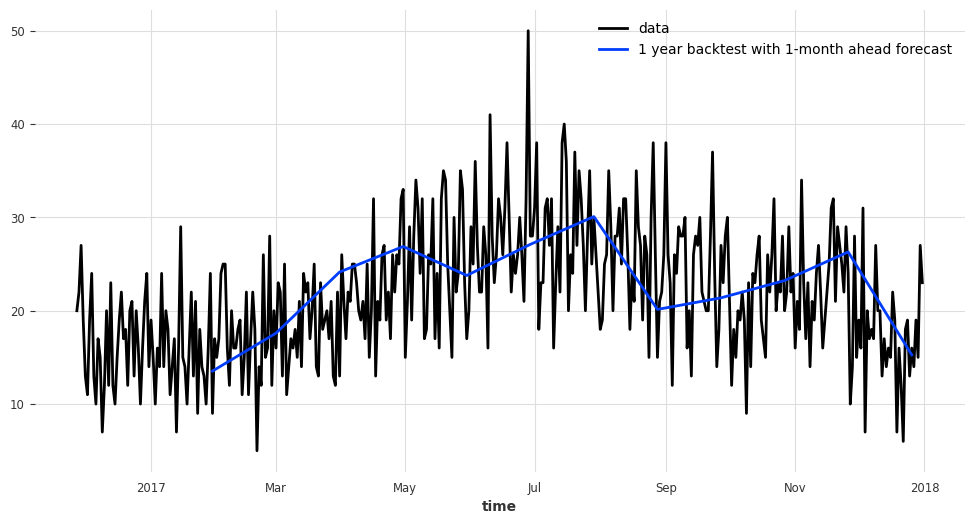

In [ ]:
backtest_horizon=365
forecast_horizon=30
start = series.time_index[-backtest_horizon]
model = Prophet(daily_seasonality=True)
model.fit(series_train)
pred=model.predict(len(series_val))

hfc_params = {
    "series": series,
    "forecast_horizon": forecast_horizon,
    "start": start,
    "verbose": True,
}

historical_fcast = model.historical_forecasts(last_points_only=True, stride=forecast_horizon,  **hfc_params)
plt.figure(figsize=(12,6))
series[-400:].plot(label="data")
historical_fcast.plot(label="1 year backtest with 1-month ahead forecast")
print(f"MAPE = {mape(series, historical_fcast):.2f}%")



  0%|          | 0/12 [00:00<?, ?it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpla3j5ss0/gofak0pk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpla3j5ss0/opdurj6f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46084', 'data', 'file=/tmp/tmpla3j5ss0/gofak0pk.json', 'init=/tmp/tmpla3j5ss0/opdurj6f.json', 'output', 'file=/tmp/tmpla3j5ss0/prophet_model8lky9ev5/prophet_model-20241030020345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:03:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:03:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:03,  2.84it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpla3j5ss0/_mezxzs3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpla3j5ss0/xyhu2fhl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmds

MAPE = 21.09%


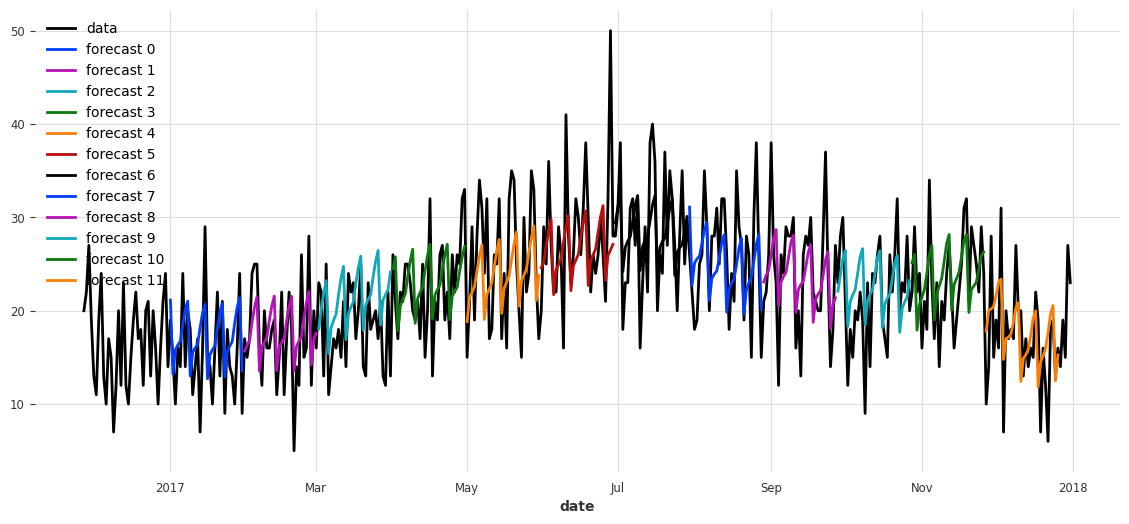

In [ ]:
historical_fcast_all = model.historical_forecasts(last_points_only=False, stride=forecast_horizon, **hfc_params)

plt.figure(figsize=(14,6))
series[-400:].plot(label="data")

for idx, hfc in enumerate(historical_fcast_all):
    hfc.plot(label=f"forecast {idx}")

historical_fcast_all = concatenate(historical_fcast_all, axis=0)
print(f"MAPE = {mape(series, historical_fcast_all):.2f}%")

  0%|          | 0/336 [00:00<?, ?it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpla3j5ss0/3eixwz35.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpla3j5ss0/nnhr6jvt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98291', 'data', 'file=/tmp/tmpla3j5ss0/3eixwz35.json', 'init=/tmp/tmpla3j5ss0/nnhr6jvt.json', 'output', 'file=/tmp/tmpla3j5ss0/prophet_modelm9ospoii/prophet_model-20241030020408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:04:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:04:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  0%|          | 1/336 [00:00<01:59,  2.80it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpla3j5ss0/20q90ih_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpla3j5ss0/u5qnhqyh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cm

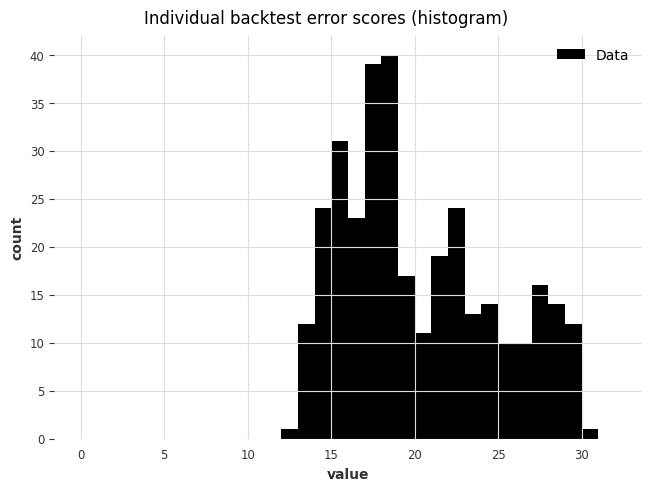

In [ ]:
raw_errors = model.backtest(metric=mape, reduction=None, last_points_only=False, stride=1, **hfc_params)
from darts.utils.statistics import plot_hist

plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title="Individual backtest error scores (histogram)",
)

**Conclusions**

1. For the backtest, I chose the Prophet model, which showed the best results.
1. When running the backtest with the parameter last_points_only=False, we obtained a "smoothed" result because only the last values for the period are included.
1. With the parameter last_points_only=True, the result includes seasonal variability.
1. The MAPE parameter was 24.45%, which is slightly higher than that after training on the entire training set (23.8%).
1p The errors are distributed in the range 12%-30%.

## General Project Conclusions

During the project, we accomplished the following:

1. **Data Preparation**: Prepared the data for analysis, ensuring it was suitable for modeling.
1. **Time Series Decomposition**: Decomposed the time series into its components, assessed seasonality, and identified significant lags relevant for forecasting.
1. **Feature Engineering**: Enriched the dataset with date-based features to enhance its predictive power.
1. **Model Experimentation**: Conducted experiments with various forecasting models and identified the one that provided the best results for our specific case.
1. **Backtesting**: Performed backtesting on the best-performing model to evaluate its predictive accuracy on historical data.